In [1]:
pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=a766dea55d6b95bf418cd7a66cbbed90662a3ac99c39335e3dadfe64344e730d
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [2]:
from pyspark.sql import SparkSession
from pyspark.ml.stat import Correlation
import pyspark.sql.functions as F
from pyspark.ml.feature import StringIndexer, OneHotEncoder

In [3]:
spark = SparkSession.builder.getOrCreate()

In [4]:
df = spark.read.csv('inventory_data.csv', inferSchema=True, header=True)

In [ ]:
from pyspark.sql.functions import col,isnan, when, count
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]
   ).show()

+---+---+---+--------+------+------+--------+
|age|sex|bmi|children|smoker|region|expenses|
+---+---+---+--------+------+------+--------+
|  0|  0|  0|       0|     0|     0|       0|
+---+---+---+--------+------+------+--------+



In [21]:
df.printSchema()

root
 |-- supermarket: string (nullable = true)
 |-- date: date (nullable = true)
 |-- month: integer (nullable = true)
 |-- year: integer (nullable = true)
 |-- product_category: string (nullable = true)
 |-- item_count: integer (nullable = true)



In [5]:
#StringIndexerForCategoricalValues

from pyspark.ml.feature import StringIndexer

indexer = StringIndexer(inputCol='supermarket', outputCol='supermarket_cat')
indexed = indexer.fit(df).transform(df)

indexer = StringIndexer(inputCol='product_category',outputCol='product_category_cat')
indexed = indexer.fit(indexed).transform(indexed)

indexed.show()

+-----------+----------+-----+----+----------------+----------+---------------+--------------------+
|supermarket|      date|month|year|product_category|item_count|supermarket_cat|product_category_cat|
+-----------+----------+-----+----+----------------+----------+---------------+--------------------+
|      Sains|2023-01-18|    1|2023| health_products|       332|            2.0|                 5.0|
|      Sains|2023-01-26|    1|2023|   food_cupboard|       323|            2.0|                 2.0|
|      Sains|2023-01-28|    1|2023|   baby_products|        39|            2.0|                 8.0|
|      Tesco|2023-01-12|    1|2023|          frozen|        47|            3.0|                 4.0|
|  Morrisons|2023-01-02|    1|2023|          drinks|       117|            1.0|                 1.0|
|  Morrisons|2023-01-07|    1|2023|          drinks|       154|            1.0|                 1.0|
|  Morrisons|2023-01-25|    1|2023|      fresh_food|       129|            1.0|            

In [7]:
from pyspark.sql.functions import dayofmonth
df_1 = indexed.withColumn('day', dayofmonth('date'))

In [8]:
df_1.show()

+-----------+----------+-----+----+----------------+----------+---------------+--------------------+---+
|supermarket|      date|month|year|product_category|item_count|supermarket_cat|product_category_cat|day|
+-----------+----------+-----+----+----------------+----------+---------------+--------------------+---+
|      Sains|2023-01-18|    1|2023| health_products|       332|            2.0|                 5.0| 18|
|      Sains|2023-01-26|    1|2023|   food_cupboard|       323|            2.0|                 2.0| 26|
|      Sains|2023-01-28|    1|2023|   baby_products|        39|            2.0|                 8.0| 28|
|      Tesco|2023-01-12|    1|2023|          frozen|        47|            3.0|                 4.0| 12|
|  Morrisons|2023-01-02|    1|2023|          drinks|       117|            1.0|                 1.0|  2|
|  Morrisons|2023-01-07|    1|2023|          drinks|       154|            1.0|                 1.0|  7|
|  Morrisons|2023-01-25|    1|2023|      fresh_food|   

In [9]:
_df = df_1.select('month','item_count','supermarket_cat','product_category_cat','day')

In [10]:
_df.show(4)

+-----+----------+---------------+--------------------+---+
|month|item_count|supermarket_cat|product_category_cat|day|
+-----+----------+---------------+--------------------+---+
|    1|       332|            2.0|                 5.0| 18|
|    1|       323|            2.0|                 2.0| 26|
|    1|        39|            2.0|                 8.0| 28|
|    1|        47|            3.0|                 4.0| 12|
+-----+----------+---------------+--------------------+---+
only showing top 4 rows



In [11]:
#creating vector space
from pyspark.ml.linalg import Vector
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(
    inputCols=['month','day','supermarket_cat', 'product_category_cat'], outputCol='feature_vectors')

sv_df = assembler.transform(_df)

In [12]:
sv_df.show()

+-----+----------+---------------+--------------------+---+-------------------+
|month|item_count|supermarket_cat|product_category_cat|day|    feature_vectors|
+-----+----------+---------------+--------------------+---+-------------------+
|    1|       332|            2.0|                 5.0| 18| [1.0,18.0,2.0,5.0]|
|    1|       323|            2.0|                 2.0| 26| [1.0,26.0,2.0,2.0]|
|    1|        39|            2.0|                 8.0| 28| [1.0,28.0,2.0,8.0]|
|    1|        47|            3.0|                 4.0| 12| [1.0,12.0,3.0,4.0]|
|    1|       117|            1.0|                 1.0|  2|  [1.0,2.0,1.0,1.0]|
|    1|       154|            1.0|                 1.0|  7|  [1.0,7.0,1.0,1.0]|
|    1|       129|            1.0|                 3.0| 25| [1.0,25.0,1.0,3.0]|
|    1|        12|            4.0|                 0.0| 16| [1.0,16.0,4.0,0.0]|
|    1|         5|            4.0|                10.0|  6| [1.0,6.0,4.0,10.0]|
|    1|       186|            2.0|      

In [13]:
final_data = sv_df.select('feature_vectors', 'item_count')

In [14]:
final_data.show(5)

+------------------+----------+
|   feature_vectors|item_count|
+------------------+----------+
|[1.0,18.0,2.0,5.0]|       332|
|[1.0,26.0,2.0,2.0]|       323|
|[1.0,28.0,2.0,8.0]|        39|
|[1.0,12.0,3.0,4.0]|        47|
| [1.0,2.0,1.0,1.0]|       117|
+------------------+----------+
only showing top 5 rows



In [15]:
#splitting data
train_data, test_data = final_data.randomSplit([.8,.2])

In [ ]:
train_data.describe().show()

+-------+------------------+
|summary|        item_count|
+-------+------------------+
|  count|             13596|
|   mean|109.31045895851722|
| stddev|  94.7106417871094|
|    min|                 1|
|    max|               390|
+-------+------------------+



In [ ]:
test_data.describe().show()

+-------+------------------+
|summary|        item_count|
+-------+------------------+
|  count|              5854|
|   mean|109.83976768021866|
| stddev|  94.3059549493958|
|    min|                 1|
|    max|               372|
+-------+------------------+



In [16]:
from pyspark.ml.regression import DecisionTreeRegressor
dt = DecisionTreeRegressor(featuresCol='feature_vectors', labelCol='item_count',maxDepth = 6)
model = dt.fit(train_data)

In [ ]:
model_eval = model.evaluate(train_data)
print(f'r2 error: {model_eval.r2}')
print(f'MeanSquaredError: {model_eval.meanSquaredError}')
print(f'MeanAbsoluteError: {model_eval.meanAbsoluteError}')

In [17]:
#making prediction

pred = model.transform(test_data.select('feature_vectors'))
pred.show()

+------------------+------------------+
|   feature_vectors|        prediction|
+------------------+------------------+
| [1.0,1.0,0.0,2.0]| 304.8434782608696|
|[1.0,1.0,0.0,10.0]|              45.5|
| [1.0,1.0,1.0,2.0]|235.49802371541503|
|[1.0,1.0,1.0,10.0]| 20.12568306010929|
| [1.0,1.0,2.0,1.0]|152.95238095238096|
| [1.0,1.0,2.0,3.0]|208.90136054421768|
| [1.0,1.0,3.0,0.0]|              32.0|
| [1.0,1.0,4.0,1.0]|              38.0|
| [1.0,1.0,4.0,3.0]|              83.0|
| [1.0,1.0,4.0,6.0]|              15.5|
| [1.0,2.0,0.0,0.0]|44.911764705882355|
| [1.0,2.0,0.0,5.0]|247.13636363636363|
| [1.0,2.0,0.0,9.0]| 215.3978102189781|
| [1.0,2.0,1.0,8.0]| 36.51724137931034|
|[1.0,2.0,1.0,10.0]| 20.12568306010929|
| [1.0,2.0,3.0,1.0]|162.65612648221344|
| [1.0,2.0,3.0,4.0]| 50.32795698924731|
| [1.0,2.0,3.0,9.0]|212.58823529411765|
| [1.0,2.0,4.0,3.0]| 97.55384615384615|
| [1.0,3.0,0.0,8.0]| 44.43666666666667|
+------------------+------------------+
only showing top 20 rows



In [18]:
pred = pred.toPandas()
actual = test_data.toPandas()

In [19]:
pred['actual'] =  actual['item_count']

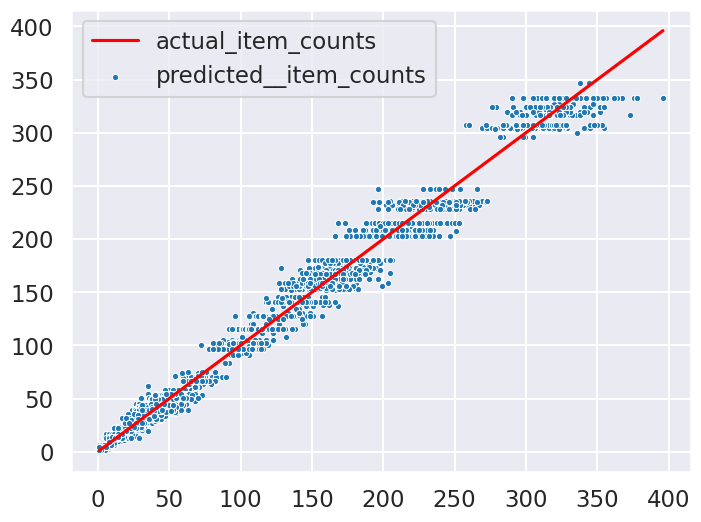

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt


plt.figure(figsize = (8,6))
sns.set_style('darkgrid')
sns.set_context('talk')

sns.lineplot(x = 'item_count', y = 'item_count', data = actual, color = 'red', label = 'actual_item_counts')
sns.scatterplot(x = 'actual', y = 'prediction', data = pred, marker = '.',label = 'predicted__item_counts')
plt.legend()
plt.xlabel('')
plt.ylabel('')

plt.show()

Ref:
https://www.projectpro.io/hadoop-tutorial/pyspark-machine-learning-tutorial

https://www.analyticsvidhya.com/blog/2022/09/machine-learning-pipeline-in-pyspark/


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import dayofmonth

# Create a SparkSession
spark = SparkSession.builder \
    .appName("Extract Day from Date Column") \
    .getOrCreate()

# Assuming you have a DataFrame named 'df' with a column 'date_column' containing dates
# You can use the dayofmonth function to extract the day
df = spark.createDataFrame([('2024-04-23',), ('2024-05-15',), ('2024-06-07',)], ['date_column'])
df = df.withColumn('day', dayofmonth('date_column'))

# Show the DataFrame
df.show()

+-----------+---+
|date_column|day|
+-----------+---+
| 2024-04-23| 23|
| 2024-05-15| 15|
| 2024-06-07|  7|
+-----------+---+

